# Comparison with experimental data
 Code to reproduce Fig. 1(c), Fig. S1 (a), (b) and (c)


# Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 10})
import pandas as pd
import random

# Function to specify properties of the axis of a plot

In [5]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

# Model 

Define the standard values of the parameters

In [8]:
# Normalized concentration of molecules c_v = [FGF]/[FGF]_0, e_v = [eph]/[eph]_0
c_v =  5  
e_v =  5 

# Total number of molecules in each cell
Rt_v =  2000 # Total number of FGF receptors
Qt_v =  2000 # Total number of ephrin receptors
Erkt_v= 4000 # Total number of ERK molecules

# Values of the reaction rates  
Kd =  60 
kd_plus_v = 0.1  
kd_minus_v = Kd*kd_plus_v
 
Ke =  40 
ke_plus_v = 0.1 
ke_minus_v = Ke*ke_plus_v

k_v =  0.2
Vs_v=  1*k_v 
Vrg_v = 0.4*k_v

# Values of half saturation constants
Ks_v =  200  
Krg_v =  200 

# Parameters input distribution (Lognormal distr centered around mu_c, with variance sigma_F^2)
mu_c = 5 
sigma_F =1

# Cell surface
Scell_v = 6000 # Total cell surface (um^2)

# The surface exposed to FGF (S1) is related to the surface exposed to ephrin (S2) through:
# S2 = A*S1+B*Scell  (Eq.5) 
A = -1.1265
B = 0.9092

Function to compute the number of active ERK molecules ($E^*$) (Eq. 1-3)

In [10]:
# Function to compute ERK as a function of the input 
# ! Here S1 is a relative surface (normalized by the total surface of the cell) ! 
def ERK(var, args, varS1=True): 

    if varS1==True: 
        S1= var 
        kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    else: 
        c= var 
        kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1+B
    Rb_ss = Rt*S1*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)
        
    return np.float32(Erk_ss) 

Function to compute the level of ERK fluorescence

In [12]:
def Fluo(var, A, B): 
    Fluo_level = var*A+B
    return Fluo_level

Function to compute the noise in the number of active ERK molecules ($\sigma_e$) (Eq. 22 - 28)

In [14]:
# Function to compute the noise as a function of the input 
# ! Here S1 is a relative surface (normalized by the total surface of the cell) ! 

def sigma(var, args, varS1=True):
    
    if varS1==True: 
        S1= var 
        kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    else: 
        c= var 
        kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B
    Rb_ss = Rt*S1*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    Tau_c = (kd_plus*c+kd_minus)**(-1)
    Tau_e = (ke_plus*e+ke_minus)**(-1)
    Tau_E = (k + Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg) )**(-1)

    Gamma_R = 2*Vs*Rb_ss*Ks**2/(Rb_ss**2+Ks**2)**2*(Erkt-Erk_ss)
    Gamma_Q = Vrg*Krg/(Qb_ss+Krg)**2*Erk_ss

    n_ss = c*kd_plus/(kd_minus + c*kd_plus)
    m_ss = e*ke_plus/(ke_minus + e*ke_plus)

    A_R = 2/Tau_c*Rt*S1*n_ss*(1-n_ss)
    A_Q = 2/Tau_e*Qt*S2*m_ss*(1-m_ss)
    A_E = 2*Vs*Rb_ss**2/(Rb_ss**2+Ks**2)*(Erkt-Erk_ss)

    sigma_R = Gamma_R**2*A_R/2*(Tau_c-Tau_E)/(Tau_E**(-2)-Tau_c**(-2))
    sigma_Q = Gamma_Q**2*A_Q/2*(Tau_e-Tau_E)/(Tau_E**(-2)-Tau_e**(-2))
    sigma_E = A_E/2*Tau_E

    sigma2 = sigma_R + sigma_Q + sigma_E
        
    return np.float32(np.sqrt(sigma2))

# Import experimental data 

In [16]:
data_S1 = pd.read_excel('./ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig1c = pd.read_excel('./ExpData.xlsx', sheet_name='Fig 1(c)')
df_Fig1c = pd.DataFrame(data_Fig1c)

data_FigS1a = pd.read_excel('./ExpData.xlsx', sheet_name='Fig S1(a)')
df_FigS1a = pd.DataFrame(data_FigS1a)

data_FigS1b = pd.read_excel('./ExpData.xlsx', sheet_name='Fig S1(b)')
df_FigS1b = pd.DataFrame(data_FigS1b)

data_FigS1c = pd.read_excel('./ExpData.xlsx', sheet_name='Fig S1(c)')
df_FigS1c = pd.DataFrame(data_FigS1c)

# Figures

## Fig. 1(c)

Experimental data 

In [19]:
# Relative S1 values
a65_S1 = np.array(df_Fig1c['a6.5 fgf relatif'].values.tolist())
a66_S1 = np.array(df_Fig1c['a6.6 fgf relatif'].values.tolist())
a67_S1 = np.array(df_Fig1c['a6.7 fgf relatif'].values.tolist())
a68_S1 = np.array(df_Fig1c['a6.8 fgf relatif'].values.tolist())

# Levels of ERK fluorescence 
a65_Erk = np.array(df_Fig1c['a6.5 dpERK'].values.tolist())
a66_Erk = np.array(df_Fig1c['a6.6 dpERK'].values.tolist())
a67_Erk = np.array(df_Fig1c['a6.7 dpERK'].values.tolist())
a68_Erk = np.array(df_Fig1c['a6.8 dpERK'].values.tolist())

Model predictions

In [21]:
S1_temp = np.linspace(0.03, 0.4, 100)

arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute the number of active ERK molecules as a function of S1 
Erk_pred = ERK(S1_temp, args=arg, varS1=True) 

# Compute the noise in the number of active ERK molecules
noise_pred = sigma(S1_temp, args=arg, varS1=True)

# Convert the number of ERK molecules and noise into levels of fluorescence
Af = 8000
Bf = 280
Erk_fluo = Fluo(Erk_pred/Erkt_v, Af, Bf)
noise_fluo = Af/Erkt_v*noise_pred


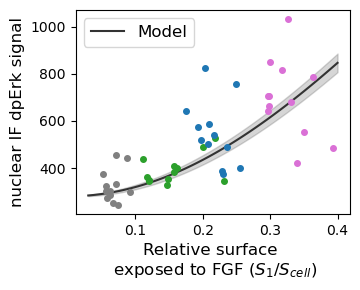

In [22]:
S1_temp_plot=S1_temp 

fig= plt.figure(figsize=(3.7,3.))
plt.fill_between(S1_temp_plot,Erk_fluo - noise_fluo, Erk_fluo + noise_fluo, alpha=0.2, color= '0.2')
plt.plot(S1_temp_plot, Erk_fluo,'-',alpha=1, color= '0.2', label='Model', zorder=1)

plt.plot(a65_S1, a65_Erk, '.', markersize=8, color='orchid', zorder=1)
plt.plot(a66_S1, a66_Erk, '.', markersize=8, color='tab:green', zorder=1)
plt.plot(a67_S1, a67_Erk, '.', markersize=8, color='tab:blue', zorder=1)
plt.plot(a68_S1, a68_Erk, '.', markersize=8, color='grey', zorder=1)

plt.legend(fontsize=12)

plt.xlabel('Relative surface \n exposed to FGF ($S_1/S_{cell}$)', fontsize=12)
plt.ylabel('nuclear IF dpErk signal', fontsize=12)

plt.tight_layout()
plt.savefig('Fig_S1c.pdf')
plt.show()

## Fig. S1(a)

Experimental data 

In [25]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

# Measured levels of Erk fluorescence 
a65_Erk_2A = np.array(df_FigS1a['a6.5'].values.tolist())
a66_Erk_2A = np.array(df_FigS1a['a6.6'].values.tolist())
a67_Erk_2A = np.array(df_FigS1a['a6.7'].values.tolist())
a68_Erk_2A = np.array(df_FigS1a['a6.8'].values.tolist())

# Compute the mean of the experimental data
mean_a65_Erk_2A = np.mean(a65_Erk_2A)
mean_a66_Erk_2A = np.mean(a66_Erk_2A)
mean_a67_Erk_2A = np.mean(a67_Erk_2A)
mean_a68_Erk_2A = np.mean(a68_Erk_2A)

mean_Erk_exp = [mean_a68_Erk_2A,mean_a66_Erk_2A,mean_a67_Erk_2A,mean_a65_Erk_2A]

# Compute the standard deviation of the experimental data
sdev_a65_Erk_exp = np.std(a65_Erk_2A)
sdev_a66_Erk_exp = np.std(a66_Erk_2A)
sdev_a67_Erk_exp = np.std(a67_Erk_2A)
sdev_a68_Erk_exp = np.std(a68_Erk_2A)

Std_exp = [sdev_a68_Erk_exp,sdev_a66_Erk_exp,sdev_a67_Erk_exp,sdev_a65_Erk_exp]

Model predictions

In [27]:
arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute the number of active ERK molecules 
ERK_a65_pred = ERK(a65_RelContactArea_A, args=arg, varS1=True)
ERK_a66_pred = ERK(a66_RelContactArea_A, args=arg, varS1=True)
ERK_a67_pred = ERK(a67_RelContactArea_A, args=arg, varS1=True)
ERK_a68_pred = ERK(a68_RelContactArea_A, args=arg, varS1=True)

# Compute the noise in the number of active ERK molecules 
sigma_a65_pred = sigma(a65_RelContactArea_A, args=arg, varS1=True)
sigma_a66_pred = sigma(a66_RelContactArea_A, args=arg, varS1=True)
sigma_a67_pred = sigma(a67_RelContactArea_A, args=arg, varS1=True)
sigma_a68_pred = sigma(a68_RelContactArea_A, args=arg, varS1=True)


# Compute ERK fluorescence 
Af = 5000
Bf = 140

Fluo_a65_pred = Fluo(ERK_a65_pred/Erkt_v, Af, Bf)
Fluo_a66_pred = Fluo(ERK_a66_pred/Erkt_v, Af, Bf)
Fluo_a67_pred = Fluo(ERK_a67_pred/Erkt_v, Af, Bf)
Fluo_a68_pred = Fluo(ERK_a68_pred/Erkt_v, Af, Bf)

# Compute the noise in the ERK fluorescence 
noise_fluo_a65_pred = Af/Erkt_v*sigma_a65_pred
noise_fluo_a66_pred = Af/Erkt_v*sigma_a66_pred
noise_fluo_a67_pred = Af/Erkt_v*sigma_a67_pred
noise_fluo_a68_pred = Af/Erkt_v*sigma_a68_pred

# Compute the mean Erk value for each cell type 
mean_a65_Fluo_model= np.mean(Fluo_a65_pred) 
mean_a66_Fluo_model= np.mean(Fluo_a66_pred)
mean_a67_Fluo_model= np.mean(Fluo_a67_pred)
mean_a68_Fluo_model= np.mean(Fluo_a68_pred)
Erk_mean_2A = [mean_a65_Fluo_model, mean_a66_Fluo_model, mean_a67_Fluo_model, mean_a68_Fluo_model]

# Compute the mean of the noise
sdev_a65_Fluo_model = np.sqrt( (1/25*np.sqrt(np.sum(noise_fluo_a65_pred**2)))**2 + (np.std(Fluo_a65_pred)**2) )
sdev_a66_Fluo_model = np.sqrt( (1/25*np.sqrt(np.sum(noise_fluo_a66_pred**2)))**2 + (np.std(Fluo_a66_pred)**2) )
sdev_a67_Fluo_model = np.sqrt( (1/25*np.sqrt(np.sum(noise_fluo_a67_pred**2)))**2 + (np.std(Fluo_a67_pred)**2) )
sdev_a68_Fluo_model = np.sqrt( (1/25*np.sqrt(np.sum(noise_fluo_a68_pred**2)))**2 + (np.std(Fluo_a68_pred)**2) )


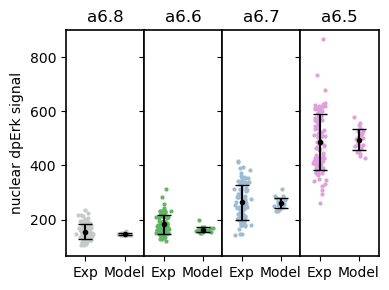

In [28]:
fig = plt.figure(figsize=(4.,3.))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8 
x = np.random.normal(1, 0.08, size=len(a68_Erk_2A))
axs[0].plot(x,a68_Erk_2A,'.', color='xkcd:silver', alpha=1,markersize=4,zorder=1)

x = 1 
axs[0].errorbar(x,mean_a68_Erk_2A ,sdev_a68_Erk_exp, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a68_pred))
axs[0].plot(x,Fluo_a68_pred,'.', color='xkcd:silver', alpha=1,markersize=4,zorder=1)

x = 2 
axs[0].errorbar(x,mean_a68_Fluo_model ,sdev_a68_Fluo_model, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[0], xlim=[0.5,2.5], ylim=[2**6,900], xticks=[1,2], title='a6.8', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')
axs[0].set_ylabel('nuclear dpErk signal')
   
# a6.6 
x = np.random.normal(1, 0.08, size=len(a66_Erk_2A))
axs[1].plot(x,a66_Erk_2A,'.', color='xkcd:boring green', alpha=1, markersize=4,zorder=1)

x = 1 
axs[1].errorbar(x,mean_a66_Erk_2A ,sdev_a66_Erk_exp, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a66_pred))
axs[1].plot(x,Fluo_a66_pred,'.', color='xkcd:boring green', alpha=1, markersize=4,zorder=1)

x = 2 
axs[1].errorbar(x,mean_a66_Fluo_model, sdev_a66_Fluo_model, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[1], xlim=[0.5,2.5], ylim=[2**6,900], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

# a6.7 
x = np.random.normal(1, 0.08, size=len(a67_Erk_2A))
axs[2].plot(x,a67_Erk_2A,'.', color='xkcd:light grey blue', alpha=1,markersize=4,zorder=1)

x = 1 
axs[2].errorbar(x,mean_a67_Erk_2A ,sdev_a67_Erk_exp, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a67_pred))
axs[2].plot(x,Fluo_a67_pred,'.', color='xkcd:light grey blue', alpha=1,markersize=4,zorder=1)

x = 2 
axs[2].errorbar(x,mean_a67_Fluo_model, sdev_a67_Fluo_model, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[2], xlim=[0.5,2.5], ylim=[2**6,900], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

# a6.5
x = np.random.normal(1, 0.08, size=len(a65_Erk_2A))
axs[3].plot(x,a65_Erk_2A,'.', color='plum', alpha=1,markersize=4,zorder=1)

x = 1 
axs[3].errorbar(x,mean_a65_Erk_2A ,sdev_a65_Erk_exp, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a65_pred))
axs[3].plot(x,Fluo_a65_pred,'.', color='plum', alpha=1,markersize=4,zorder=1)

x = 2 
axs[3].errorbar(x,mean_a65_Fluo_model, sdev_a65_Fluo_model, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[3], xlim=[0.5,2.5], ylim=[2**6,900], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

plt.tight_layout()
plt.savefig('Fig_S1a.pdf')
plt.show()


## Fig. S1(b)

Experimental data 

In [31]:
# Convert the databases into lists 
a65_Erk_S1C = np.array(df_FigS1b['a6.5'].values.tolist())
a66_Erk_S1C = np.array(df_FigS1b['a6.6'].values.tolist())
a67_Erk_S1C = np.array(df_FigS1b['a6.7'].values.tolist())
a68_Erk_S1C = np.array(df_FigS1b['a6.8'].values.tolist())

# Compute means of exp data
mean_a65_Erk_S1C = np.mean(a65_Erk_S1C)
mean_a66_Erk_S1C = np.mean(a66_Erk_S1C)
mean_a67_Erk_S1C = np.mean(a67_Erk_S1C)
mean_a68_Erk_S1C = np.mean(a68_Erk_S1C)

mean_Erk_exp_S1C = [mean_a65_Erk_S1C, mean_a66_Erk_S1C, mean_a67_Erk_S1C, mean_a68_Erk_S1C]

# Compute std of exp data
sdev_a65_S1C = np.std(a65_Erk_S1C)
sdev_a66_S1C = np.std(a66_Erk_S1C)
sdev_a67_S1C = np.std(a67_Erk_S1C)
sdev_a68_S1C = np.std(a68_Erk_S1C)

Model predictions 

In [33]:
arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute the number of active ERK molecules 
ERK_a65_pred_S1C = ERK(a65_RelContactArea_A, args=arg, varS1=True)
ERK_a66_pred_S1C = ERK(a66_RelContactArea_A, args=arg, varS1=True)
ERK_a67_pred_S1C = ERK(a67_RelContactArea_A, args=arg, varS1=True)
ERK_a68_pred_S1C = ERK(a68_RelContactArea_A, args=arg, varS1=True)

# Compute ERK fluorescence 
Af = 8000
Bf = 180

Fluo_a65_pred_S1C = Fluo(ERK_a65_pred_S1C/Erkt_v, Af, Bf)
Fluo_a66_pred_S1C = Fluo(ERK_a66_pred_S1C/Erkt_v, Af, Bf)
Fluo_a67_pred_S1C = Fluo(ERK_a67_pred_S1C/Erkt_v, Af, Bf)
Fluo_a68_pred_S1C = Fluo(ERK_a68_pred_S1C/Erkt_v, Af, Bf)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Fluo_model_S1C= np.mean(Fluo_a65_pred_S1C) 
mean_a66_Fluo_model_S1C= np.mean(Fluo_a66_pred_S1C)
mean_a67_Fluo_model_S1C= np.mean(Fluo_a67_pred_S1C)
mean_a68_Fluo_model_S1C= np.mean(Fluo_a68_pred_S1C)
Erk_mean_S1C = [mean_a65_Fluo_model_S1C, mean_a66_Fluo_model_S1C, mean_a67_Fluo_model_S1C, mean_a68_Fluo_model_S1C]

# Compute the noise for each cell type 
sdev_a65_Fluo_model_S1C = np.std(Fluo_a65_pred_S1C)
sdev_a66_Fluo_model_S1C = np.std(Fluo_a66_pred_S1C)
sdev_a67_Fluo_model_S1C = np.std(Fluo_a67_pred_S1C)
sdev_a68_Fluo_model_S1C = np.std(Fluo_a68_pred_S1C)

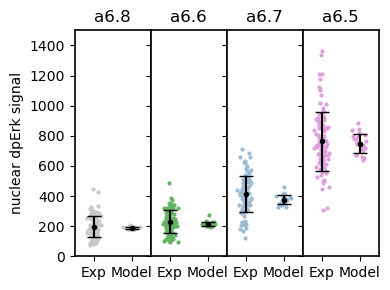

In [34]:
fig = plt.figure(figsize=(4.,3.))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8 
x = np.random.normal(1, 0.08, size=len(a68_Erk_S1C))
axs[0].plot(x,a68_Erk_S1C,'.', color='xkcd:silver', alpha=1,markersize=4,zorder=1)

x = 1 
axs[0].errorbar(x,mean_a68_Erk_S1C ,sdev_a68_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a68_pred_S1C))
axs[0].plot(x,Fluo_a68_pred_S1C,'.', color='xkcd:silver', alpha=1,markersize=4,zorder=1)

x = 2 
axs[0].errorbar(x,mean_a68_Fluo_model_S1C ,sdev_a68_Fluo_model_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[0], xlim=[0.5,2.5], ylim=[0,1500], xticks=[1,2], title='a6.8', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')
axs[0].set_ylabel('nuclear dpErk signal')
   
# a6.6 
x = np.random.normal(1, 0.08, size=len(a66_Erk_S1C))
axs[1].plot(x,a66_Erk_S1C,'.', color='xkcd:boring green', alpha=1, markersize=4,zorder=1)

x = 1 
axs[1].errorbar(x,mean_a66_Erk_S1C ,sdev_a66_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a66_pred_S1C))
axs[1].plot(x,Fluo_a66_pred_S1C,'.', color='xkcd:boring green', alpha=1, markersize=4,zorder=1)

x = 2 
axs[1].errorbar(x,mean_a66_Fluo_model_S1C, sdev_a66_Fluo_model_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[1], xlim=[0.5,2.5], ylim=[0,1500], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

# a6.7 
x = np.random.normal(1, 0.08, size=len(a67_Erk_S1C))
axs[2].plot(x,a67_Erk_S1C,'.', color='xkcd:light grey blue', alpha=1,markersize=4,zorder=1)

x = 1 
axs[2].errorbar(x,mean_a67_Erk_S1C ,sdev_a67_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a67_pred_S1C))
axs[2].plot(x,Fluo_a67_pred_S1C,'.', color='xkcd:light grey blue', alpha=1,markersize=4,zorder=1)

x = 2 
axs[2].errorbar(x,mean_a67_Fluo_model_S1C, sdev_a67_Fluo_model_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[2], xlim=[0.5,2.5], ylim=[0,1500], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

# a6.5
x = np.random.normal(1, 0.08, size=len(a65_Erk_S1C))
axs[3].plot(x,a65_Erk_S1C,'.', color='plum', alpha=1,markersize=4,zorder=1)

x = 1 
axs[3].errorbar(x,mean_a65_Erk_S1C ,sdev_a65_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Fluo_a65_pred_S1C))
axs[3].plot(x,Fluo_a65_pred_S1C,'.', color='plum', alpha=1,markersize=4,zorder=1)

x = 2 
axs[3].errorbar(x,mean_a65_Fluo_model_S1C, sdev_a65_Fluo_model_S1C, marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[3], xlim=[0.5,2.5], ylim=[0,1500], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True, scale='lin')

plt.tight_layout()
plt.savefig('Fig_S1b.pdf')
plt.show()




## Fig. S1(c)

Experimental data 

In [37]:
# Relative contact area with FGF expressing cells 
a65_S1_noE = np.array(df_FigS1c['a65 fgf relatif'].values.tolist())
a66_S1_noE = np.array(df_FigS1c['a66 fgf relatif'].values.tolist())
a67_S1_noE = np.array(df_FigS1c['a67 fgf relatif'].values.tolist())
a68_S1_noE = np.array(df_FigS1c['a68 fgf relatif'].values.tolist())

# ERK fluorescence level
a65_Erk_noE = np.array(df_FigS1c['a65 dpERK'].values.tolist())
a66_Erk_noE = np.array(df_FigS1c['a66 dpERK'].values.tolist())
a67_Erk_noE = np.array(df_FigS1c['a67 dpERK'].values.tolist())
a68_Erk_noE = np.array(df_FigS1c['a68 dpERK'].values.tolist())

Model predictions

In [39]:
S1_temp = np.linspace(0.03, 0.35, 100)
c_v = 5
e_v= 1e-10
arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute Erk as a function of S1 (The model computes the number of ERK molecules)
Erk_pred_noeph = ERK(S1_temp, args=arg, varS1=True) 
noise_pred_noeph = sigma(S1_temp, args= arg, varS1=True)


# Convert the number of ERK molecules into levels of fluorescence
Af = 10000
Bf = 250
noise_fluo_noE = np.sqrt( (Af/Erkt_v*noise_pred_noeph)**2 )  # + (np.nanstd(a68_Erk_noE))**2 )

Erk_fluo_noeph = Fluo(Erk_pred_noeph/Erkt_v, Af, Bf)
Erk_fluo_minusnoise_noeph = Erk_fluo_noeph - noise_fluo_noE
Erk_fluo_plusnoise_noeph = Erk_fluo_noeph + noise_fluo_noE


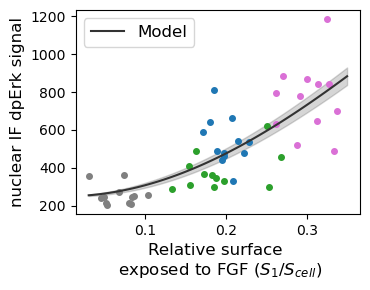

In [40]:
S1_temp_plot= S1_temp

fig= plt.figure(figsize=(3.8,3))
plt.fill_between(S1_temp_plot, Erk_fluo_minusnoise_noeph, Erk_fluo_plusnoise_noeph, alpha=0.2, color= '0.2')
plt.plot(S1_temp_plot, Erk_fluo_noeph,'-',alpha=1, color= '0.2', label='Model', zorder=2)

plt.plot(a65_S1_noE, a65_Erk_noE,'.', markersize=8, color='orchid', zorder=1)
plt.plot(a66_S1_noE, a66_Erk_noE,'.', markersize=8, color='tab:green', zorder=1)
plt.plot(a67_S1_noE, a67_Erk_noE,'.', markersize=8, color='tab:blue', zorder=1)
plt.plot(a68_S1_noE, a68_Erk_noE,'.', markersize=8, color='grey', zorder=1)

#plt.title('In the absence of ephrin', fontsize=14)

plt.legend(fontsize=12)
plt.xlabel('Relative surface \n exposed to FGF ($S_1/S_{cell}$)', fontsize=12)
plt.ylabel('nuclear IF dpErk signal', fontsize=12)
plt.tight_layout()
plt.savefig('Fig_S1c.pdf')
plt.show()